In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.container { font-size:16px !important; }</style>"))

import numpy as np 
import matplotlib.pyplot as plt 

from matplotlib import rcParams
#rcParams['font.family'] = 'sans'
#rcParams['font.sans-serif'] = ['Tahoma']
rcParams['font.size'] = 20
#rcParams['text.usetex'] = True
import matplotlib.pyplot as plt

The goal of this exercise is to try and go through radiative transfer process and calculate all the quantities needed to calculate a spectrum of the line.

In general, the problem is very hard. Here we are going to simplify it a lot. This is by no means realistic, but at least number do make sense. For starters we are going to open atmospheric model, famous falc. 

The model is described by total of 12 parameters at 57 depth points. We need the following columns: 

1 - height (in cm) 

2 - Temperature (in K)

3 - total gas pressure (in cm$^-3$)

We are going to work in SI (Hurray!)

In [2]:
atmos = np.loadtxt("falc.dat",unpack=True,skiprows=1) #load the atmos 

Text(0.5, 0, 'h [km]')

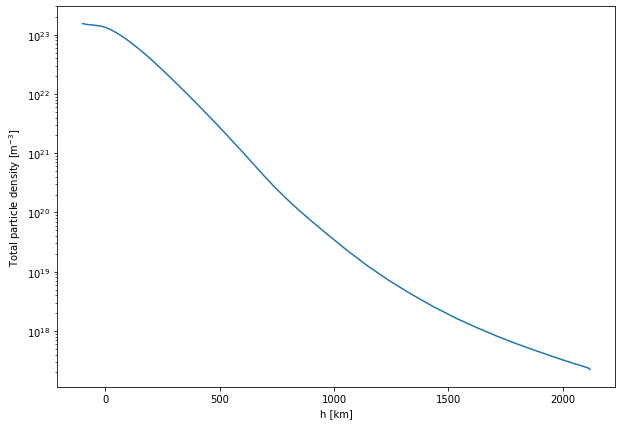

In [3]:
h = atmos[1]/ 1E2 # height in meters
N_total = atmos[3] / 1.38E-16 / atmos[2] # transform total gass pressure to the total number of particles 
N_total *= 1E6 # transform to m^{-3} 

plt.figure(figsize=[10,7])
plt.semilogy(h/1E3,N_total)
plt.ylabel("Total particle density $\mathrm{[m^{-3}]}$")
plt.xlabel("h [km]")

See the total number of particles decreases almost exponentially. And changes by 6 orders of magnitude! 

Now the next step is to calculate relevant number densities from this. We are assuming the atmosphere consists solely of Hydrogen. So we have tree species: electrons, protons and neutral hydrogen. The equations that we need to solve are the following ones: 
$$ n_e = n_p $$
$$ n_e + n_p + n_0 = N_{total} $$
$$\frac{n_p n_e }{n_0} = f(T) $$

Where $f(T)$ follows from the Saha equation. Let's et on to it:

Text(0, 0.5, '$\\mathrm{log} n_e / n_0$')

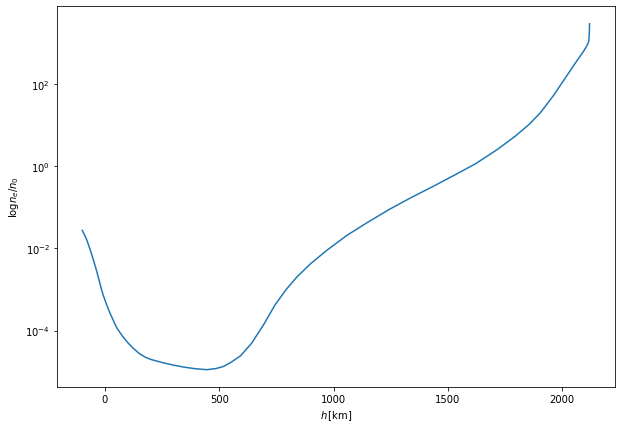

In [4]:
k = 1.38E-23 #Boltzmann constant 
me = 9.1E-31 # electron mass 
hp = 6.626E-34 #Planck function
c = 299792458. # speed of light

C_I = 0.5 * (2.0*np.pi*me*k/hp/hp)**-1.5 # constant term in saha equation

T = atmos[2]
E_ion = 2.17896E-18 # ionization energy of hydrogen in Joules

#Saha, 'factor', S, coming from saha equation n_i+i * n_e / n_i = f(T)
f = 0.5 * np.exp(-E_ion/k/T) /C_I * T**1.5

# It can be shown that electron density is the positive solution of the quadratic equation
n_e = (-2.0 * f + (4*f*f + 4*f*N_total)**0.5 ) * 0.5
n_0 = n_e**2.0 / f

#print (n_e / n_0)

plt.figure(figsize=[10,7])
plt.semilogy(h/1E3,n_e/n_0)
plt.xlabel('$h\,\mathrm{[km]}$')
plt.ylabel('$\mathrm{log} n_e / n_0$')


We saw this in the previous class. Ionization factor goes from something very small in the photosphere, to very high values in the chromosphere. This is both because of temperature rise AND the density drop.

Now, let's calculate populations of level 2 and level 3 of hidrogen. Partition function of H is roughly 2 everywhere, unless temperatures are ridiculous. 

To calculate level populations we  will, of course use Boltzmann distribution:

Text(0, 0.5, 'Population')

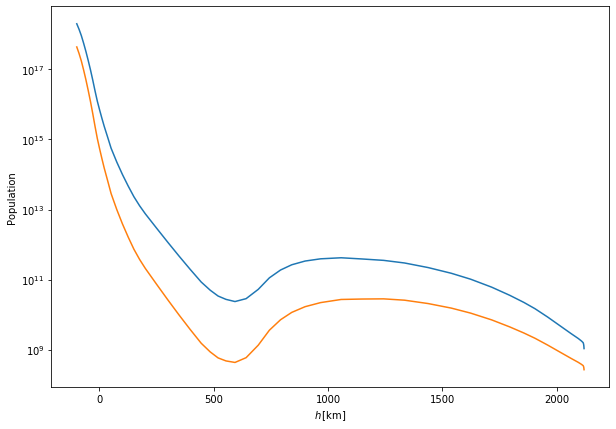

In [5]:
E_2 = 10.1988357  * 1.60218e-19 # second level energy in Joules
E_3 = 12.0875051  * 1.60218e-19 # third level
g_2 = 8.0 # statistical weight / degeneracy
g_3 = 18.0

n_2 = n_0 * np.exp(-E_2/k/T)*g_2 / 2.0 # 2 is the partition function of hydrogen
n_3 = n_0 * np.exp(-E_3/k/T)*g_3 / 2.0

plt.figure(figsize=[10,7])
plt.semilogy(h/1E3,n_2,label='Level 2')
plt.semilogy(h/1E3,n_3,label='Level 3')

plt.xlabel('$h\,\mathrm{[km]}$')
plt.ylabel('Population')

Great, now is the time to calculate opacity and emissivity. But keep in mind that these are also wavelength dependent! So, let's make a wavelength grid too!

In [6]:
llambda = np.linspace(6558.0,6568.0,401)*1E-10 # this is roughly 0.025 Angstrom spacing
llambda *= 1.00029 # We are used to working in air wavelengths, but we need to convert to vacuum now ;) 

ND = len(T) #number of depths
NL = len(llambda) #number of wavelengts

# line center wavelength
llambda0 = hp*c/(E_3 - E_2)

m_h = 1.67E-27 # mass of Hydrogen in kg, we need this for doppler width

opacity = np.zeros([ND,NL])
emissivity = np.zeros([ND,NL])

In [7]:
# Now our beloved Einstein coefficients:

A_32 = 4.4101e+07
B_32 = A_32 / (2.*hp*c*c/llambda0**5.0)
B_23 = B_32 * g_3 / g_2

In [8]:
# Time to calculate opacity and emissivity! 

for d in range(0,ND): #for each depth
    
    # calculate doppler velocity
    dvd = np.sqrt(2*k*T[d]/m_h)
    
    # calculate doppler widht in wavelength units (m)
    dld = llambda0 / c * dvd
    
    # calculate Gaussian profile 
    profile = 1./np.sqrt(np.pi)/dld * np.exp(-(llambda-llambda0)**2.0/dld/dld)
    
    # calculate opacity and emissivity
    opacity[d,:] = (n_2[d] * B_23 - n_3[d]*B_32) * hp*c/llambda0 / 4. / np.pi * profile
    emissivity[d,:] = n_3[d] * A_32 * hp*c/llambda0 / 4. / np.pi * profile
    
    
    

Let's consider which units are these. Should be J / m^2 / srad / s ,right! :-) 

Let's calculate Planck function at Halpha line center for our whole atmosphere and compare. That to ratio of opacity and emissivity (the source function)

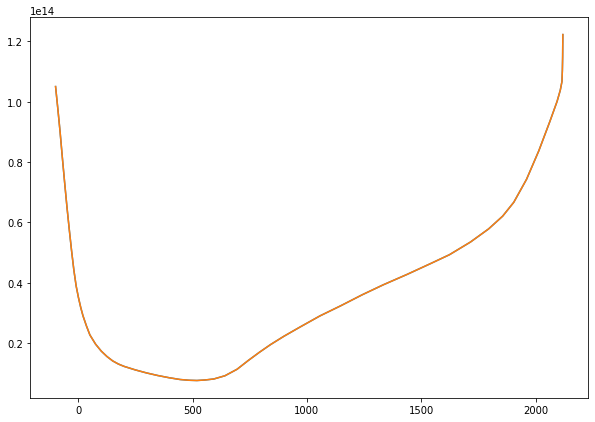

In [9]:
B = 2.0 * hp * c **2.0 / llambda0**5.0 * 1./ (np.exp(hp*c/llambda0/k/T)-1.0)
plt.figure(figsize=[10,7])
plt.plot(h/1E3,emissivity[:,200] / opacity[:,200])
plt.plot(h/1E3,B)

Spot on! Looks good for now. Now, it's the time to calculate the optical depthm and see if if makes sense. I am going to integrate opacity starting from the top of the atmosphere (do not be confused index 0 is the top!). I am going to use simplest trapezoidal integration.

In [10]:
tau = np.zeros([ND,NL])
for d in range(1,ND):
    tau[d,:] = tau[d-1,:] + 0.5*(opacity[d,:]+opacity[d-1,:])* np.fabs((h[d-1]-h[d]))
    

Ok, let's plot "continuum" (i.e. far from line center) in log scale.

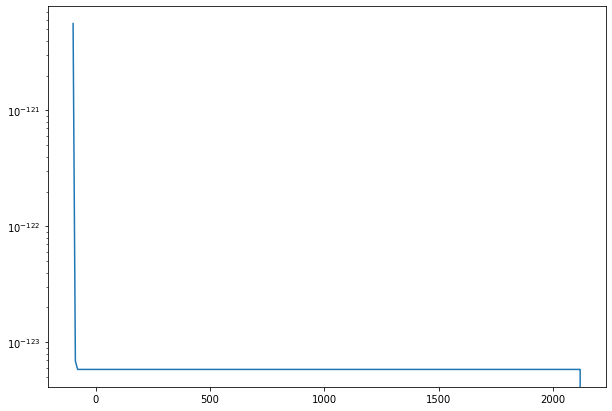

In [11]:
plt.figure(figsize=[10,7])
plt.semilogy(h/1E3,tau[:,0])

Obviously far from the line core we have ridiculously small opacity. Let's increase it a bit by adding some H- continuum opacity.

We are considering only B-F opacity of negative hydrogen ion.

Following David F. Gray's "Observation and Analysis of Stellar Photospheres", we have, for the cross-section of negative ion of hydrogen

We are going to work in CGS and then finally convert to SI :) 

In [12]:
alpha = 1.99654 - 1.18267E-5 * llambda0 + 2.64243E-6 * llambda0 **2.0 - 4.40524E-10* llambda0**3.0 + 3.23992E-14 * llambda0 **4.0 -1.39568E-18 * llambda0**5.0 + 2.78701E-23 * llambda0**6.0
alpha *= 1E-18 # in cm^2

The next step is to try and to calculate opacity per hydrogen atom, given electron pressure, etc. We are continuing to use the approach by D.F.Gray: 

In [13]:
theta = 5040./T #Temperature proxy
Pe = k*T*n_e # electron pressure
Pe *= 10. # to convert to cgs
kappa = 4.158E-10 * alpha * Pe * (theta ** 2.5) * (10.** (0.754*theta))
opacity_h_minus = kappa*(n_0/1E6) #converting neutral hydrogen density to cm! 
opacity_h_minus *= 100.0 # to convert from per cm to per m! 


Text(0, 0.5, 'Continuum opacity due to H- opacity')

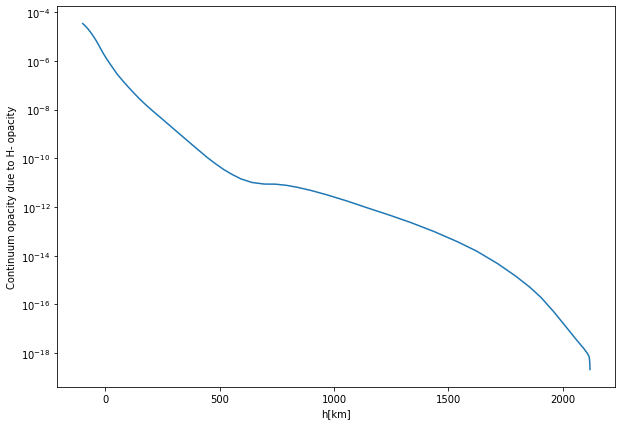

In [14]:
plt.figure(figsize=[10,7])
plt.semilogy(h/1E3,opacity_h_minus)
plt.xlabel("h[km]")
plt.ylabel("Continuum opacity due to H- opacity")

This does not seem bad. The only way to check is to re-calculate opacity and see if it makes sense.

In [15]:
opacity += opacity_h_minus[:,None]

In [16]:
# Let's also see where the line center is, that would be handy ;) 
l_core = np.argmax(opacity[-1])
print (l_core)

186


Seems reasonable. Let's now re-calculate optical depth and take a look:

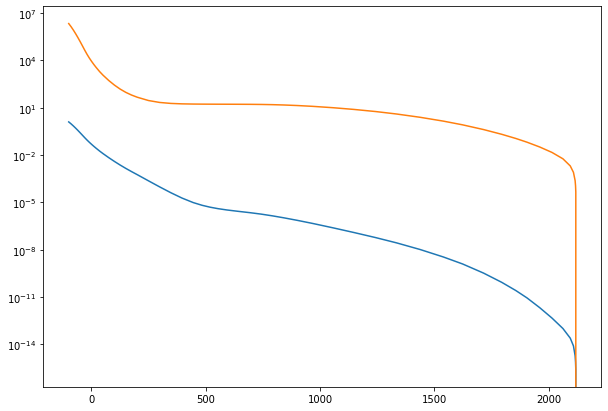

In [17]:
tau = np.zeros([ND,NL])
for d in range(1,ND):
    tau[d,:] = tau[d-1,:] + 0.5*(opacity[d,:]+opacity[d-1,:])* np.fabs((h[d-1]-h[d]))
    
plt.figure(figsize=[10,7])
plt.semilogy(h/1E3,tau[:,0])
plt.semilogy(h/1E3,tau[:,l_core])

The total optical depth of the continuum seems a bit low. Seems like we do not have enough H- opacity. I will tell you in class why that is. (Main reasons are we need other sources + there is not enough electrons here). Let's artificially tweak this so we see something reasonable. How to tweak this? 

Well we know at h ~ 0 km $\tau$ in the continuum should be around 1.

In [18]:
for d in range(0,ND):
    print (d,h[d],tau[d,0])

0 2119280.0 0.0
1 2118400.0 2.597800515782404e-16
2 2117290.0 7.642547393025463e-16
3 2115430.0 1.933178289057473e-15
4 2108100.0 8.140348354756883e-15
5 2094100.0 2.5251650600062483e-14
6 2062130.0 1.0246012748605068e-13
7 2014280.0 4.712754916525382e-13
8 1960530.0 2.1534996412713376e-12
9 1904840.0 8.97472051962643e-12
10 1856210.0 2.6134128428202603e-11
11 1794570.0 8.658286234843508e-11
12 1715310.0 3.3221008565143756e-10
13 1623330.0 1.2645727420409823e-09
14 1538970.0 3.5161394812342635e-09
15 1437530.0 1.0421840516065159e-08
16 1334410.0 2.7495486023300968e-08
17 1242790.0 5.9411247390992636e-08
18 1147430.0 1.2497952433054113e-07
19 1057090.0 2.456406576206182e-07
20 967298.0 4.6820083789996275e-07
21 899577.0 7.38059266619755e-07
22 841150.0 1.0646021443095354e-06
23 792180.0 1.4113997215037325e-06
24 743337.0 1.8127320186366483e-06
25 694663.0 2.2368729530491446e-06
26 641527.0 2.73918369190594e-06
27 592939.0 3.3321157139745474e-06
28 553646.0 4.042217346597104e-06
29 51911

Ok instead of being rouhgly one, it is ~ 0.05, some 20 times low! Let's add additional 20 x H- opacity to fix this ad-hoc!

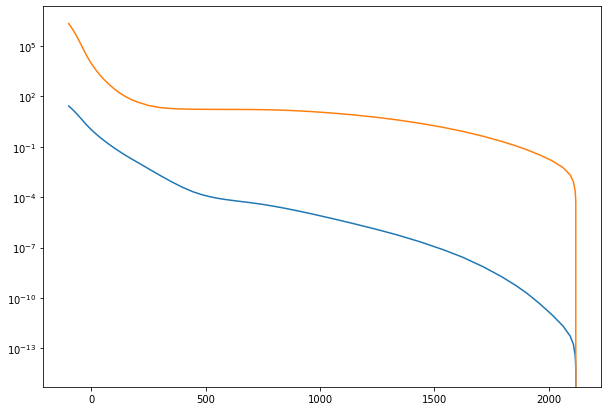

In [21]:
opacity += 20.*opacity_h_minus[:,None]
tau = np.zeros([ND,NL])
for d in range(1,ND):
    tau[d,:] = tau[d-1,:] + 0.5*(opacity[d,:]+opacity[d-1,:])* np.fabs((h[d-1]-h[d]))
    
plt.figure(figsize=[10,7])
plt.semilogy(h/1E3,tau[:,0])
plt.semilogy(h/1E3,tau[:,l_core])

Not perfect but considering that we are simulating the whole RT code in one class, I am not unhappy! 

The next step would be to calculate the emissivity of neutral hydrogen atom. Since, to solve RTE, we need optical depth and the source function. I propose we use planck function as the source function since we don't have time and resources to do NLTE anyway.

How to do the formal solution? The easiest is to treat the atmosphere as a series of homogeneous slabs. Solution for one slab is: 
$$I_\lambda^+ = I_\lambda^0 e^{-\Delta\tau_\lambda} + S(1-e^{-\Delta\tau_\lambda})$$ 

We will take the lower boundary to be identical to the Source function there and start moving up. Let's go! 

In [22]:
I = np.zeros([ND,NL])
# Boundary condition
I[ND-1] = B[ND-1]
for d in range(ND-2,-1,-1):
    delta_tau = tau[d+1]-tau[d]
    I[d] = I[d+1] * np.exp(-delta_tau) + (B[d+1]+B[d])*0.5 * (1.0 -np.exp(-delta_tau))

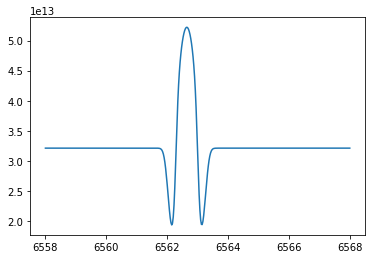

In [23]:
plt.plot(llambda*1E10 / 1.00029,I[0])

There are various things we can do now. Use your imagination to expand the code using the following tweaks: 

1 - Adding some collisional damping to get more reasonable line shape 

2 - Increasing or decreasing line opacity to simulate behaviors of different lines 

3 - Artificially decrease the source function in the higher layers to simulate NLTE effects. 

The options are limitless ;) 